In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.model_selection import train_test_split
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

unable to import 'smart_open.gcs', disabling that module


In [85]:
ted = pd.read_csv('data/ted_full_v2.csv')

In [78]:
submission = pd.read_csv("data/submission_topics_feats.csv")

In [120]:
(submission['preds'] != submission['actuals']).sum()

5

In [99]:
submission.columns = ['url', 'proba', 'preds', 'actuals']

In [103]:
ted = ted.merge(submission, on = 'url', how = 'left')

In [125]:
ted.loc[:, 'days_since_publish'] = ((pd.to_datetime(['2017-09-21']).astype(int) / 10**9) - ted['published_date']) / (60 * 60 * 24)
ted.loc[:, 'days_since_publish'] = 935 + ted.loc[:, 'days_since_publish']
ted.loc[:, 'super_popular'] = "Correctly Classified = No"
ted.loc[ted['view_2020'] > 4000000, 'super_popular'] = "Correctly Classified = Yes"

In [126]:
ted.loc[ted['actuals'] != ted['preds'], 'super_popular'] = "Misclassified"

In [146]:
col_dict = {"Correctly Classified = No":"darkred", 
            "Correctly Classified = Yes":"darkblue", 
            "Misclassified":"lightgreen"}

/Users/altamashrafiq/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/altamashrafiq/opt/anaconda3/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
  PlotnineWarning)


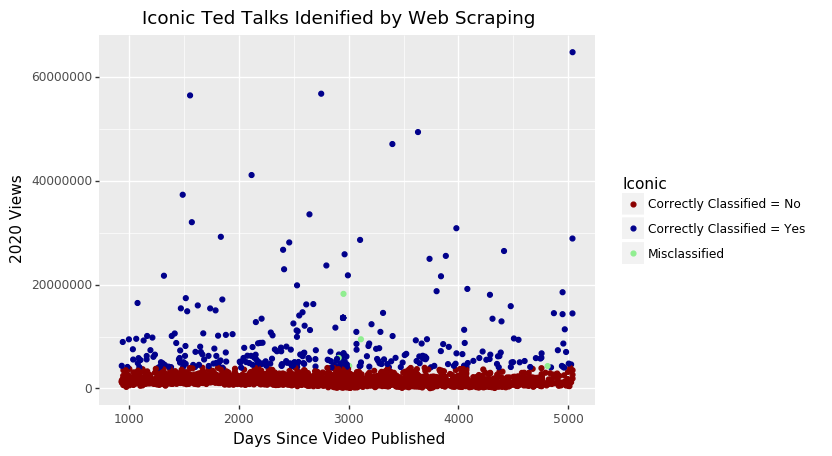

<ggplot: (313734069)>

In [147]:
(ggplot(ted, aes(x = 'days_since_publish', y = 'view_2020', color = 'factor(super_popular)')) +
       geom_point() +
       labs(color = "Iconic") + xlab("Days Since Video Published") +
       ylab("2020 Views") + ggtitle("Iconic Ted Talks Idenified by Web Scraping") + 
       scale_color_manual(values = col_dict) +
       scale_fill_manual(values = col_dict))

In [30]:
ted.loc[:, 'laugh_count'] = ted['transcript'].str.count("(Laughter)")
ted.loc[:, 'applause_count'] = ted['transcript'].str.count("(Applause)")
ted.loc[:, 'days_since_publish'] = ((pd.to_datetime(['2017-09-25']).astype(int) / 10**9) - ted['published_date']) / (60 * 60 * 24)
ted.loc[:, 'lifetime_virality'] = ted['views'] / ted['days_since_publish']
ted.loc[:, 'super_popular'] = 0
ted.loc[ted['views'] > 4000000, 'super_popular'] = 1
ted.loc[ted['speaker_occupation'].str.contains('Artist|artist') == True, 'speaker_occupation'] = "Artist"
ted.loc[ted['speaker_occupation'].str.contains('Author|author|Writer|writer') == True, 'speaker_occupation'] = "Writer"
ted.loc[ted['speaker_occupation'].isin(small_occupations) == True, 'speaker_occupation'] = "Other"
# ted['transcript'] = (ted['transcript'].str.replace("\\'", "")
#                      .str.replace("\(Laughter\)", " ")
#                      .str.replace("\(Applause\)", " ")
#                      .str.lower()
#                      .str.translate(str.maketrans('()—', ' '*len('()—')))
#                      .str.translate(str.maketrans('', '', string.punctuation))
#                      .str.translate(str.maketrans('', '', string.digits)))

NameError: name 'small_occupations' is not defined

In [28]:
# transcripts = (ted['transcript'].apply(word_tokenize)
#                                 .apply(
#                                     lambda x: [item for item in x if item not in stopwords.words('english')]
#                                 ))

In [67]:
sifted = ['description', 'duration', 'event', 'main_speaker', 'name', 'speaker_occupation',
          'title', 'transcript', 'laugh_count', 'applause_count', 'days_since_publish', 'super_popular']
ted = ted[sifted]

In [68]:
train = ted.loc[ted['days_since_publish'] > 250]
test = ted.loc[ted['days_since_publish'] <= 250]

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop(['super_popular'], axis = 1), train[['super_popular']], 
    test_size = 0.2, random_state = 42)